# core

> Fill in a module description here

In [1]:
# | default_exp core

In [2]:
# | hide
from nbdev.showdoc import *

## Imports

In [3]:
%load_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'retina'
import datetime
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set()
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = 10, 6
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.precision = 4
warnings.simplefilter(action="ignore", category=FutureWarning)

dollar_formatter = FuncFormatter(lambda x, pos: f"${x:,.0f}")
thousands_formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

## Data

In [4]:
canada_births_1991_2022 = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/canada_births_1991_2022.csv"
)
nhl_player_births = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_player_births.csv"
)
nhl_rosters = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_rosters.csv"
)
nhl_teams = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-09/nhl_teams.csv"
)

In [5]:
nhl_rosters['season'].value_counts()

season
20212022    1212
20222023    1161
20032004    1128
20182019    1099
20022003    1093
20202021    1078
20012002    1075
20002001    1073
20052006    1068
20172018    1067
20152016    1067
20142015    1065
20112012    1060
20102011    1059
20132014    1058
20082009    1055
20162017    1053
20192020    1053
20092010    1049
20062007    1041
19992000    1035
19981999    1028
20072008    1010
19951996     993
19931994     987
20122013     984
19971998     944
19961997     944
19941995     895
19911992     884
19921993     857
19901991     821
19881989     809
19871988     807
20232024     798
19891990     795
19851986     754
19811982     745
19831984     743
19861987     742
19791980     709
19821983     709
19841985     707
19801981     702
19741975     560
19771978     558
19781979     532
19761977     532
19751976     526
19731974     485
19721973     438
19701971     431
19711972     428
19681969     352
19691970     346
19671968     345
19341935     200
19331934     195
1965196

## Functions

In [6]:
def filter_players(df, nationality):
    """
    Filter players based on nationality.

    Parameters:
    - df (DataFrame): The input dataframe containing player information.
    - nationality (str): The nationality to filter by. Use "CAN" for Canadian players, or leave empty for no filter.

    Returns:
    - filtered_df (DataFrame): The filtered dataframe based on the nationality.
    """
    if nationality == "CAN":
        return df[df["birth_country"] == "CAN"]
    elif nationality == "":
        return df
    else:
        return df[df["birth_country"] != "CAN"]


def linear_weight(month):
    """
    Calculate the linear weight for a given month.

    Parameters:
    - month (int): The month for which to calculate the weight.

    Returns:
    - weight (int): The linear weight for the given month.
    """
    # Assuming month is an integer from 1 (January) to 12 (December)
    return month


def logistic_weight(month, midpoint=6.5, growth_rate=1, max_value=12):
    """
    Calculate the logistic weight for a given month.

    Parameters:
    - month (int): The month for which to calculate the weight.
    - midpoint (float): The midpoint of the logistic function. Default is 6.5.
    - growth_rate (float): The growth rate of the logistic function. Default is 1.
    - max_value (float): The maximum value of the logistic function. Default is 12.

    Returns:
    - weight (float): The logistic weight for the given month.
    """
    return max_value / (1 + np.exp(-growth_rate * (month - midpoint)))


def calculate_metric(birth_months, weight_function):
    """
    Calculate a metric based on the birth months and a weight function.

    Parameters:
    - birth_months (list): A list of birth months.
    - weight_function (function): The weight function to use for calculating the metric.

    Returns:
    - metric (float): The calculated metric.
    """
    weighted_sum = sum(weight_function(month) for month in birth_months)
    return weighted_sum / len(birth_months)


def raw_to_cleaned_canada(df_):
    """
    Clean the raw Canada birth dataframe.

    Parameters:
    - df_ (DataFrame): The raw Canada birth dataframe.

    Returns:
    - cleaned_df (DataFrame): The cleaned Canada birth dataframe with a new "yearmonth" column.
    """
    return df_.assign(yearmonth=pd.to_datetime(df_[["year", "month"]].assign(day=1)))


def raw_to_cleaned_nhl_player_births(df_):
    """
    Clean the raw NHL player births dataframe.

    Parameters:
    - df_ (DataFrame): The raw NHL player births dataframe.

    Returns:
    - cleaned_df (DataFrame): The cleaned NHL player births dataframe with a new "birth_date" column.
    """
    return df_.assign(birth_date=pd.to_datetime(df_["birth_date"]))


def simulate_player_birth_skew(n_players=100, n_simulations=10):
    """
    Simulate the player birth skew by randomly selecting birth months based on the Canadian birth rate.

    Parameters:
    - n_players (int): Number of players to simulate. Default is the size of nhl_player_births.
    - n_simulations (int): Number of simulations to run. Default is 10.

    Returns:
    - weights (ndarray): An array containing the calculated metric for each simulation.
    """

    # Initialize an empty list to store the calculated metric for each simulation
    weights = []

    # Run the simulations
    for sim in range(n_simulations):
        # Randomly select birth months based on the Canadian birth rate
        birth_months = np.random.choice(
            canadian_births_percentage.index,
            p=canadian_births_percentage.values / 100,
            replace=True,
            size=n_players,
        )

        # Calculate the metric using the linear weight function
        weight = calculate_metric(birth_months, linear_weight)

        # Append the calculated metric to the list
        weights.append(weight)

    return np.array(weights)

In [7]:
canadian_players_by_birth = filter_players(nhl_player_births, nationality="CAN")
noncanadian_players_by_birth = filter_players(nhl_player_births, nationality="non Canadian")
all_players_by_birth = filter_players(nhl_player_births, nationality="")

clean_canada_births = raw_to_cleaned_canada(canada_births_1991_2022)
clean_nhl_player_births = raw_to_cleaned_nhl_player_births(nhl_player_births)


canadian_births_percentage = (
    clean_canada_births.groupby("month")["births"].sum()
    / clean_canada_births["births"].sum()
    * 100.0
)

## EDA

In [8]:
n_players = nhl_player_births["player_id"].nunique()

## Plots

### What does the birth rate for Canadians look like (agg monthly)?

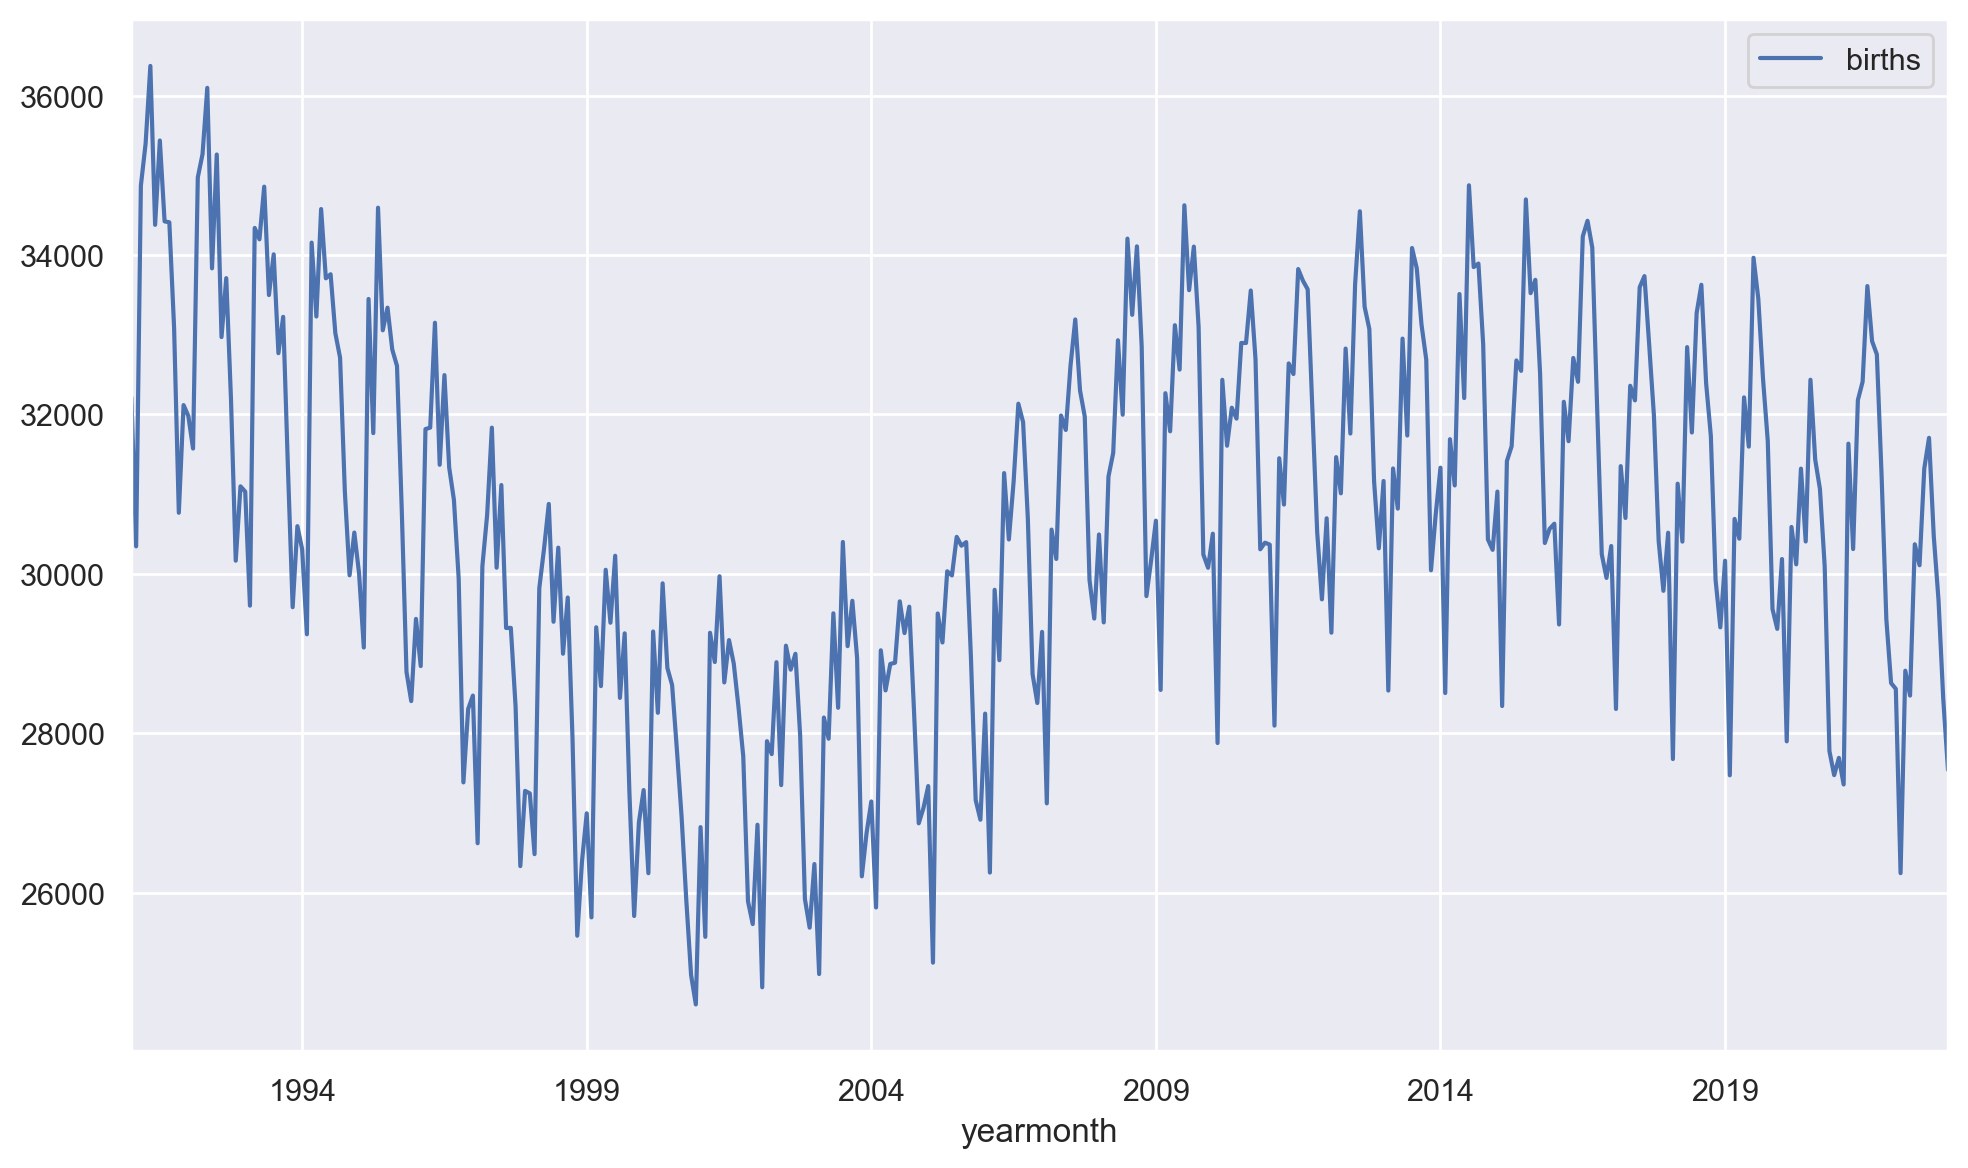

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
clean_canada_births.plot(x="yearmonth", y="births", ax=ax)
fig.tight_layout()

In [10]:
clean_canada_births.head()

,year,month,births,yearmonth
0,1991,1,32213,1991-01-01
1,1991,2,30345,1991-02-01
2,1991,3,34869,1991-03-01
3,1991,4,35398,1991-04-01
4,1991,5,36371,1991-05-01


In [11]:
clean_canada_births.tail()

,year,month,births,yearmonth
379,2022,8,31706,2022-08-01
380,2022,9,30472,2022-09-01
381,2022,10,29671,2022-10-01
382,2022,11,28428,2022-11-01
383,2022,12,27540,2022-12-01


In [12]:
# Check if the sum of Canadian births percentage is close to 100
assert np.isclose(canadian_births_percentage.sum(), 100.0)

### What does the monthly birth rate for Canadians look like?

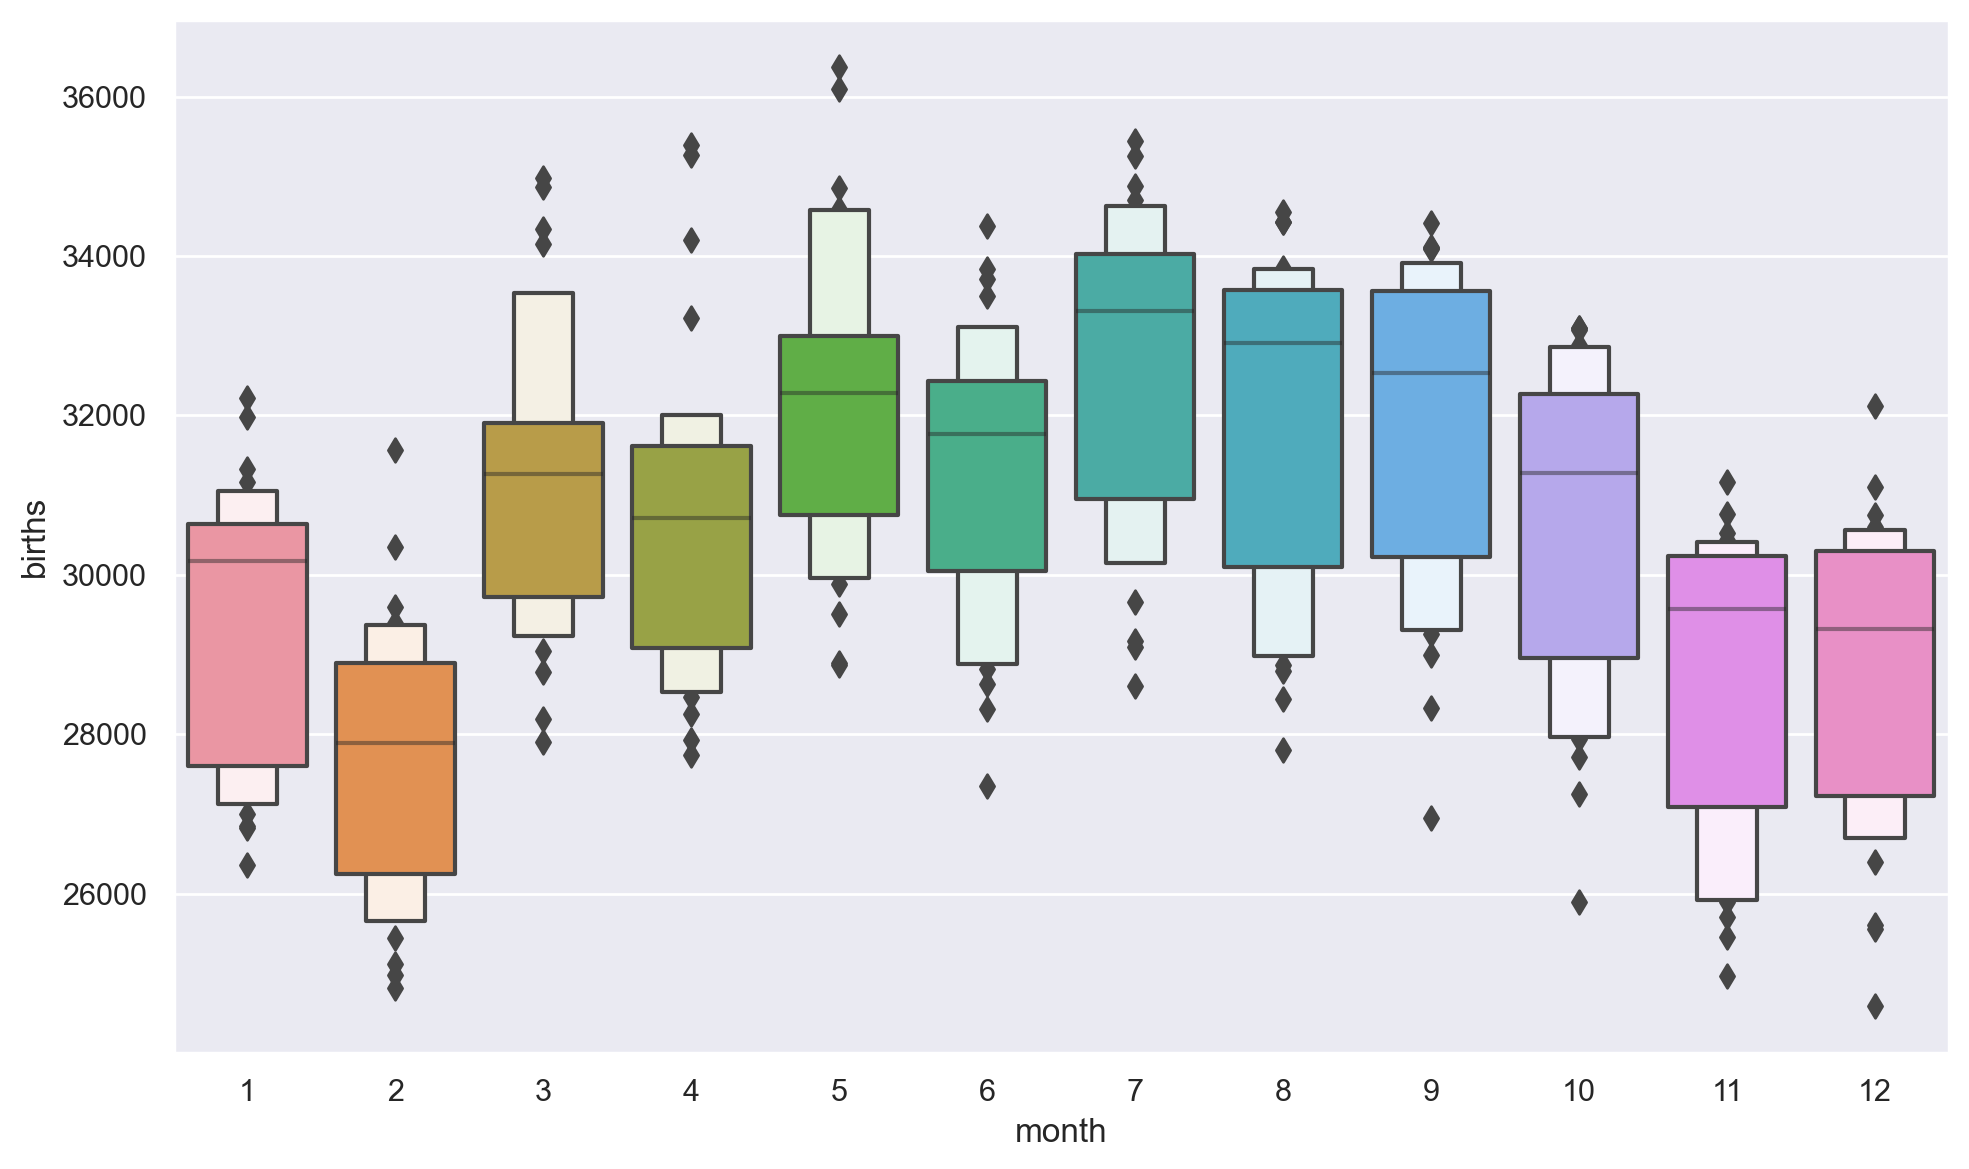

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(data=clean_canada_births, ax=ax, x="month", y="births")
fig.tight_layout()

### What does the monthly birth rate for NHL players look like?

In [14]:
clean_nhl_player_births.head()[["player_id", "birth_month"]]

,player_id,birth_month
0,8467867,3
1,8445176,9
2,8460014,4
3,8460510,5
4,8459596,8


In [15]:
g = clean_nhl_player_births.groupby(["birth_month"]).count()["player_id"]

In [16]:
month_counts = clean_nhl_player_births["birth_month"].value_counts().sort_index()

In [17]:
month_counts

# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {"Month": month_counts.index, "Player Count": month_counts.values}
)

# Create the boxenplot

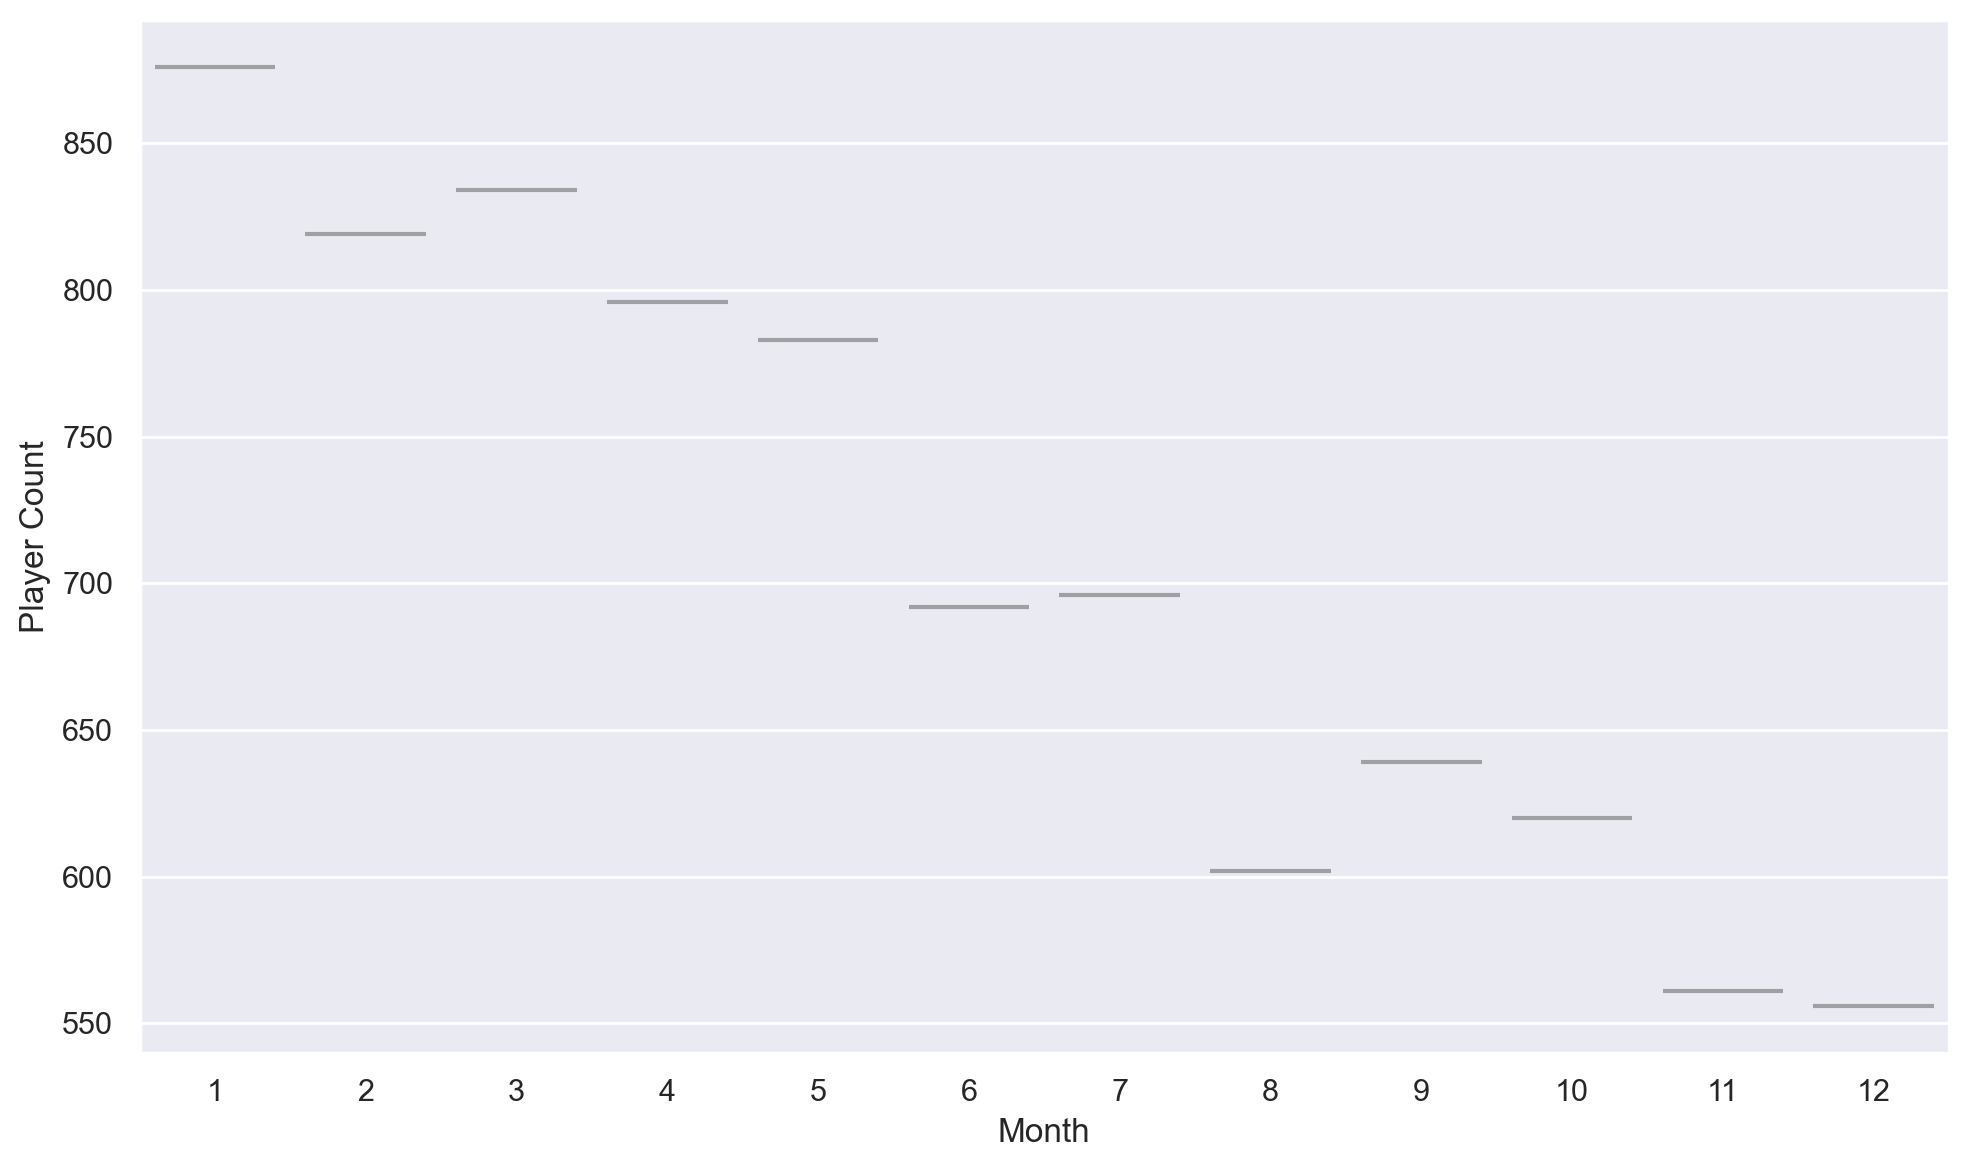

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(x="Month", y="Player Count", data=plot_data, ax=ax)
# ax.xaxis.set_major_formatter(dollar_formatter)
fig.tight_layout()

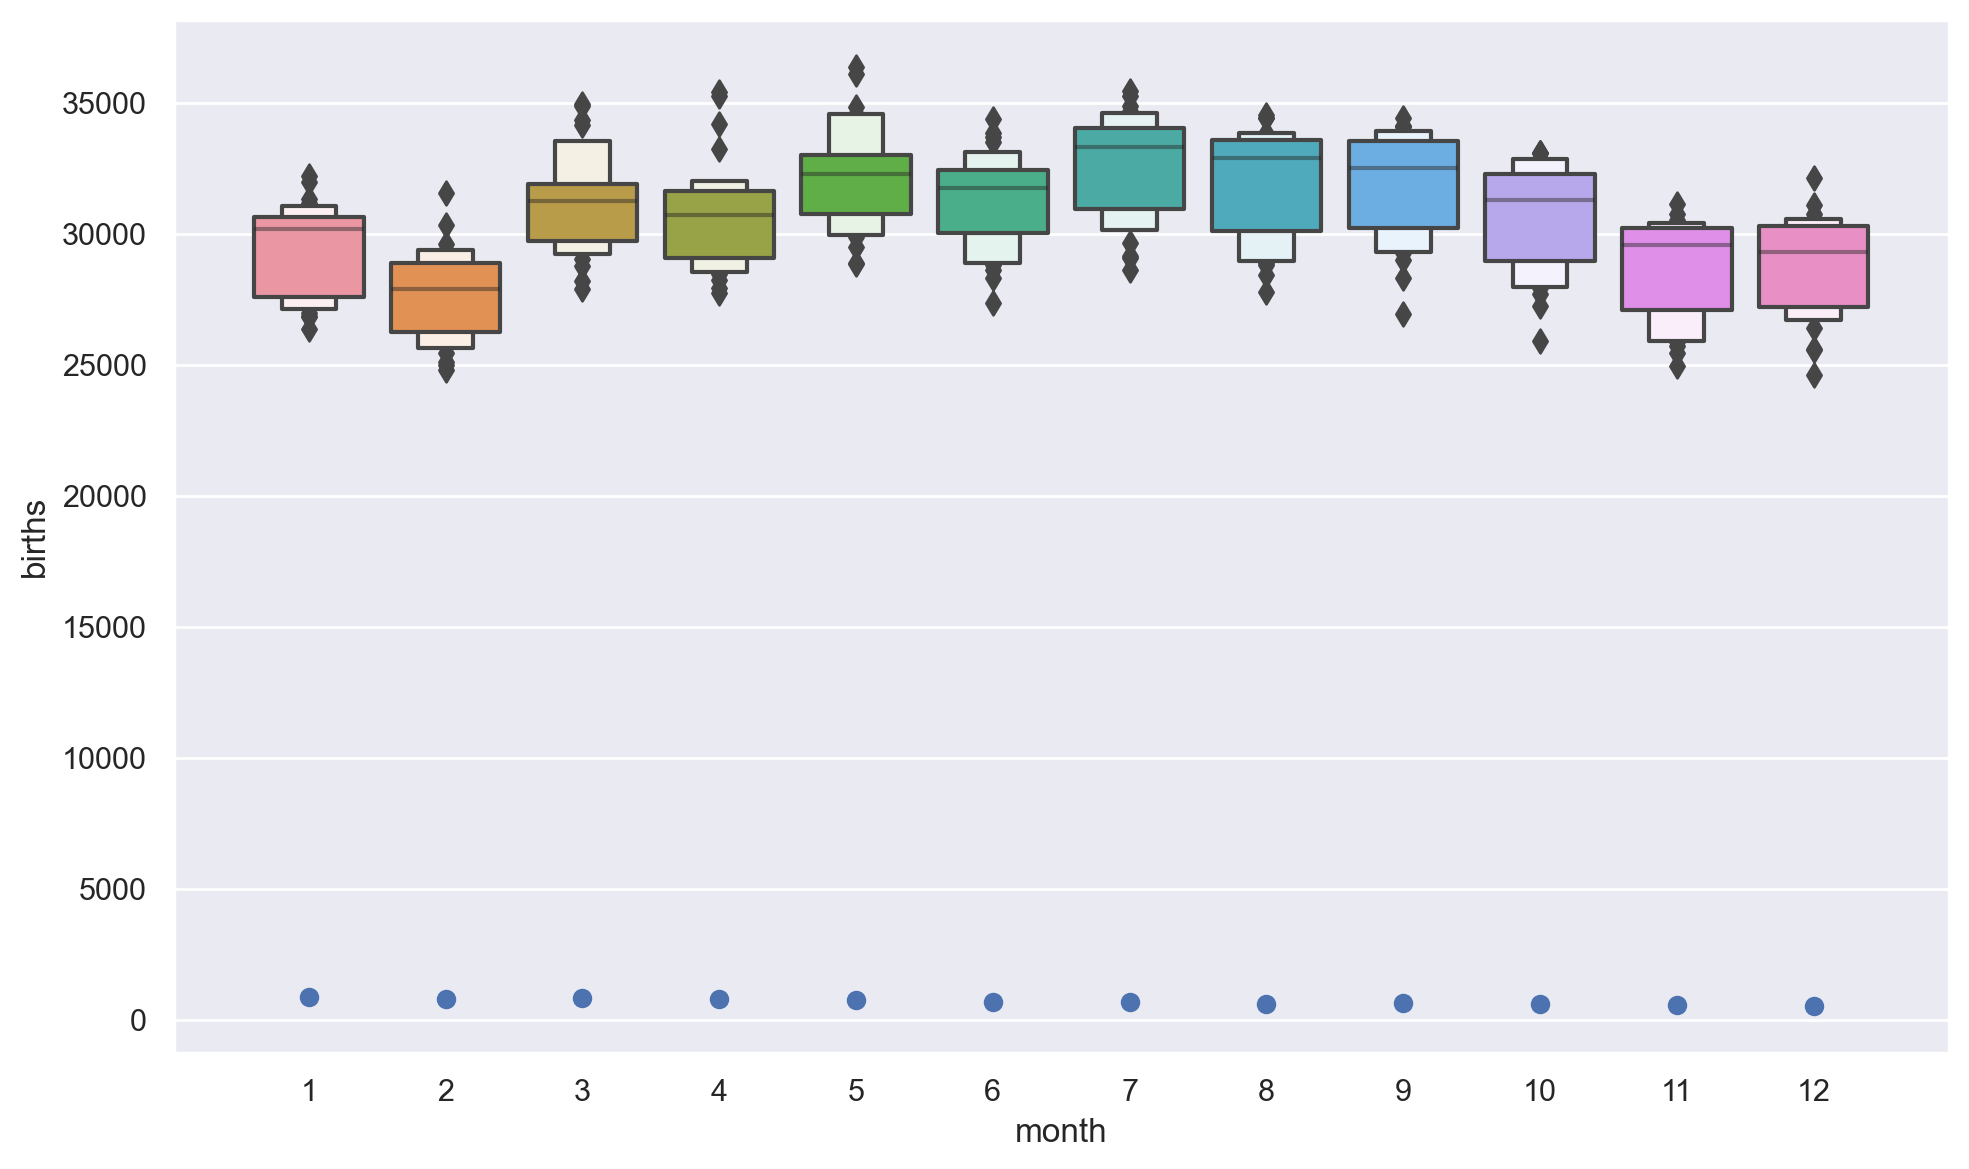

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.boxenplot(data=clean_canada_births, ax=ax, x="month", y="births")
ax.scatter(g.index - 1, g)
fig.tight_layout()

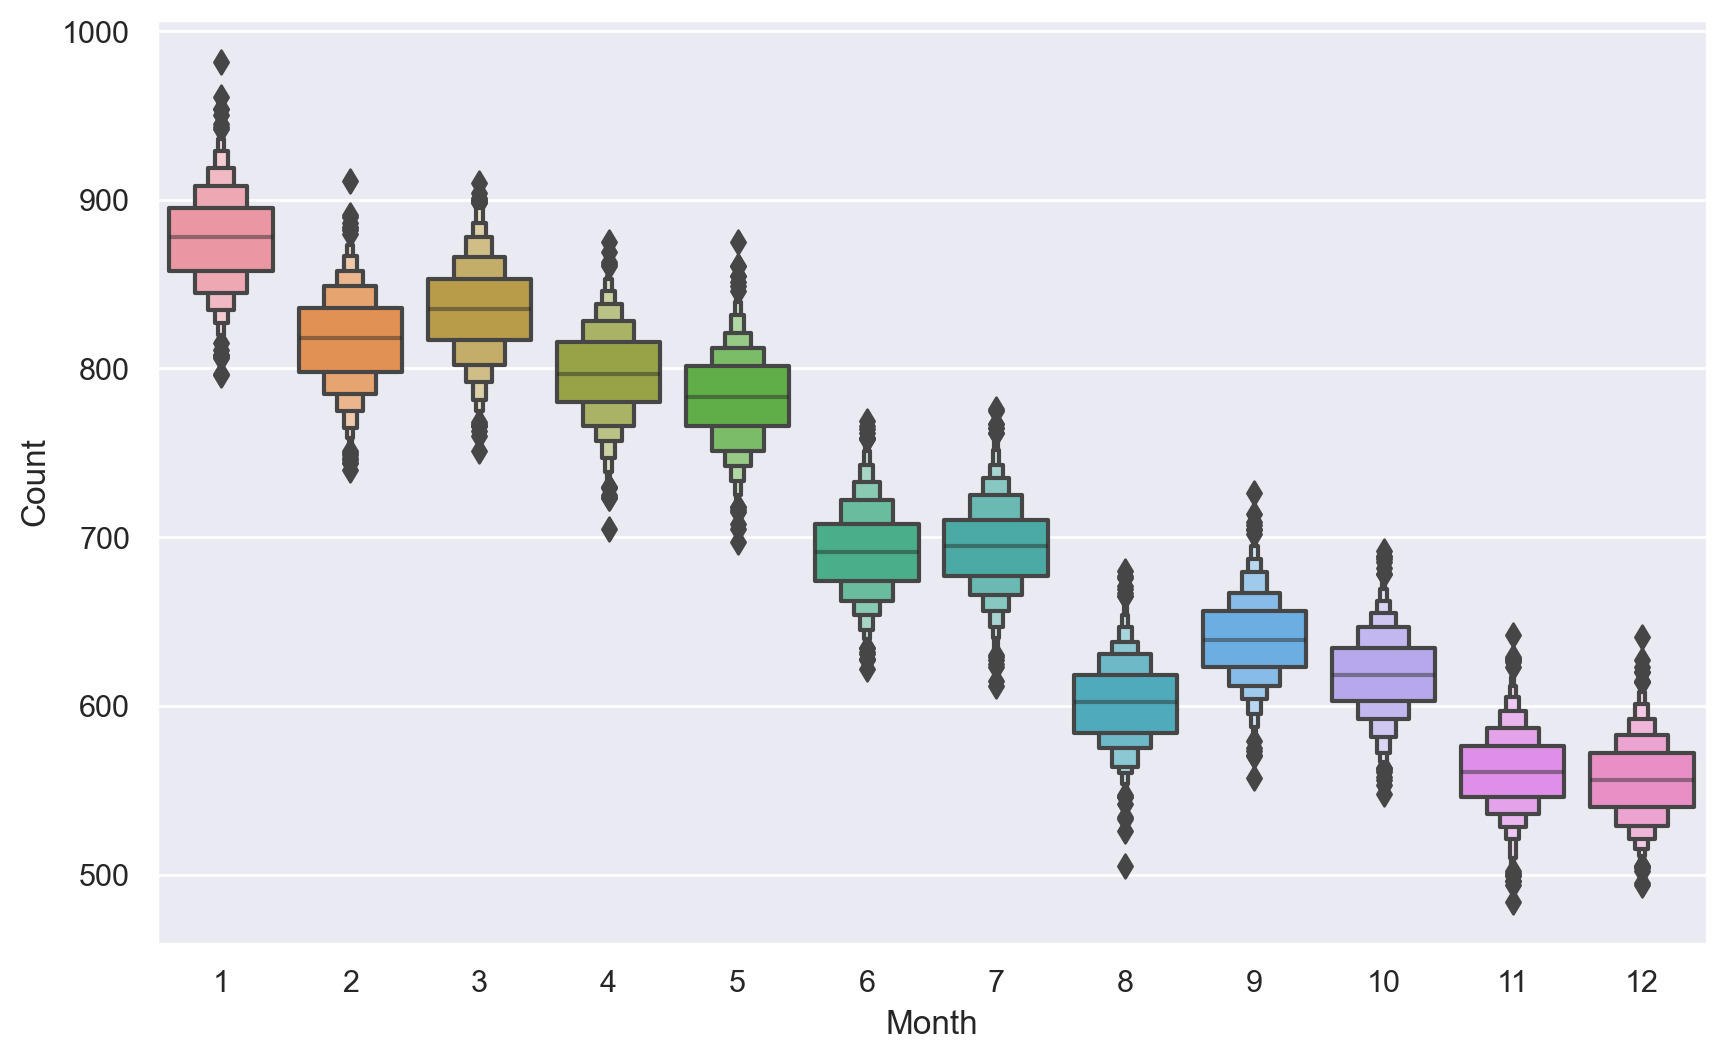

In [20]:
# Number of bootstrap iterations
n_iterations = 1000

# List to store bootstrap samples
bootstrap_samples_list = []

for i in range(n_iterations):
    # Sample the entire dataset with replacement
    sample = clean_nhl_player_births.sample(frac=1, replace=True)
    # Count the number of players for each month in the sample
    month_counts = sample["birth_month"].value_counts().sort_index()
    # Store the counts with the month information
    for month in month_counts.index:
        bootstrap_samples_list.append({"Month": month, "Count": month_counts[month]})

# Concatenate all samples into a DataFrame
bootstrap_samples = pd.concat(
    [pd.DataFrame([sample]) for sample in bootstrap_samples_list], ignore_index=True
)

# Now plot the data
sns.boxenplot(x="Month", y="Count", data=bootstrap_samples)
plt.show()

# NHL players are preferentially born "early" in the year

### Define early in the year

Each month gets its numerical value as it's "weight". January -> 1, December -> 12.

### Create a metric

A linear weighting of the months that appear in a data set.

### Simulate

I will draw from the NHL players roster; and I will randomly draw from the general Canadian population birth month distribution. Do this process 10,000 times. Create a distribution of the metric. 

### Compare


### Visualize


In [21]:
weights = simulate_player_birth_skew(
    n_players=canadian_players_by_birth["player_id"].nunique(), n_simulations=1000
)

In [22]:
# todo add test that early and late years have different metric values

assert calculate_metric(np.random.randint(1, 8, size=100), linear_weight)  < 6.5
assert calculate_metric(np.random.randint(5, 12, size=100), linear_weight) > 6.5

In [23]:
weights = simulate_player_birth_skew(
    n_players=canadian_players_by_birth["player_id"].nunique(), n_simulations=10_000
)

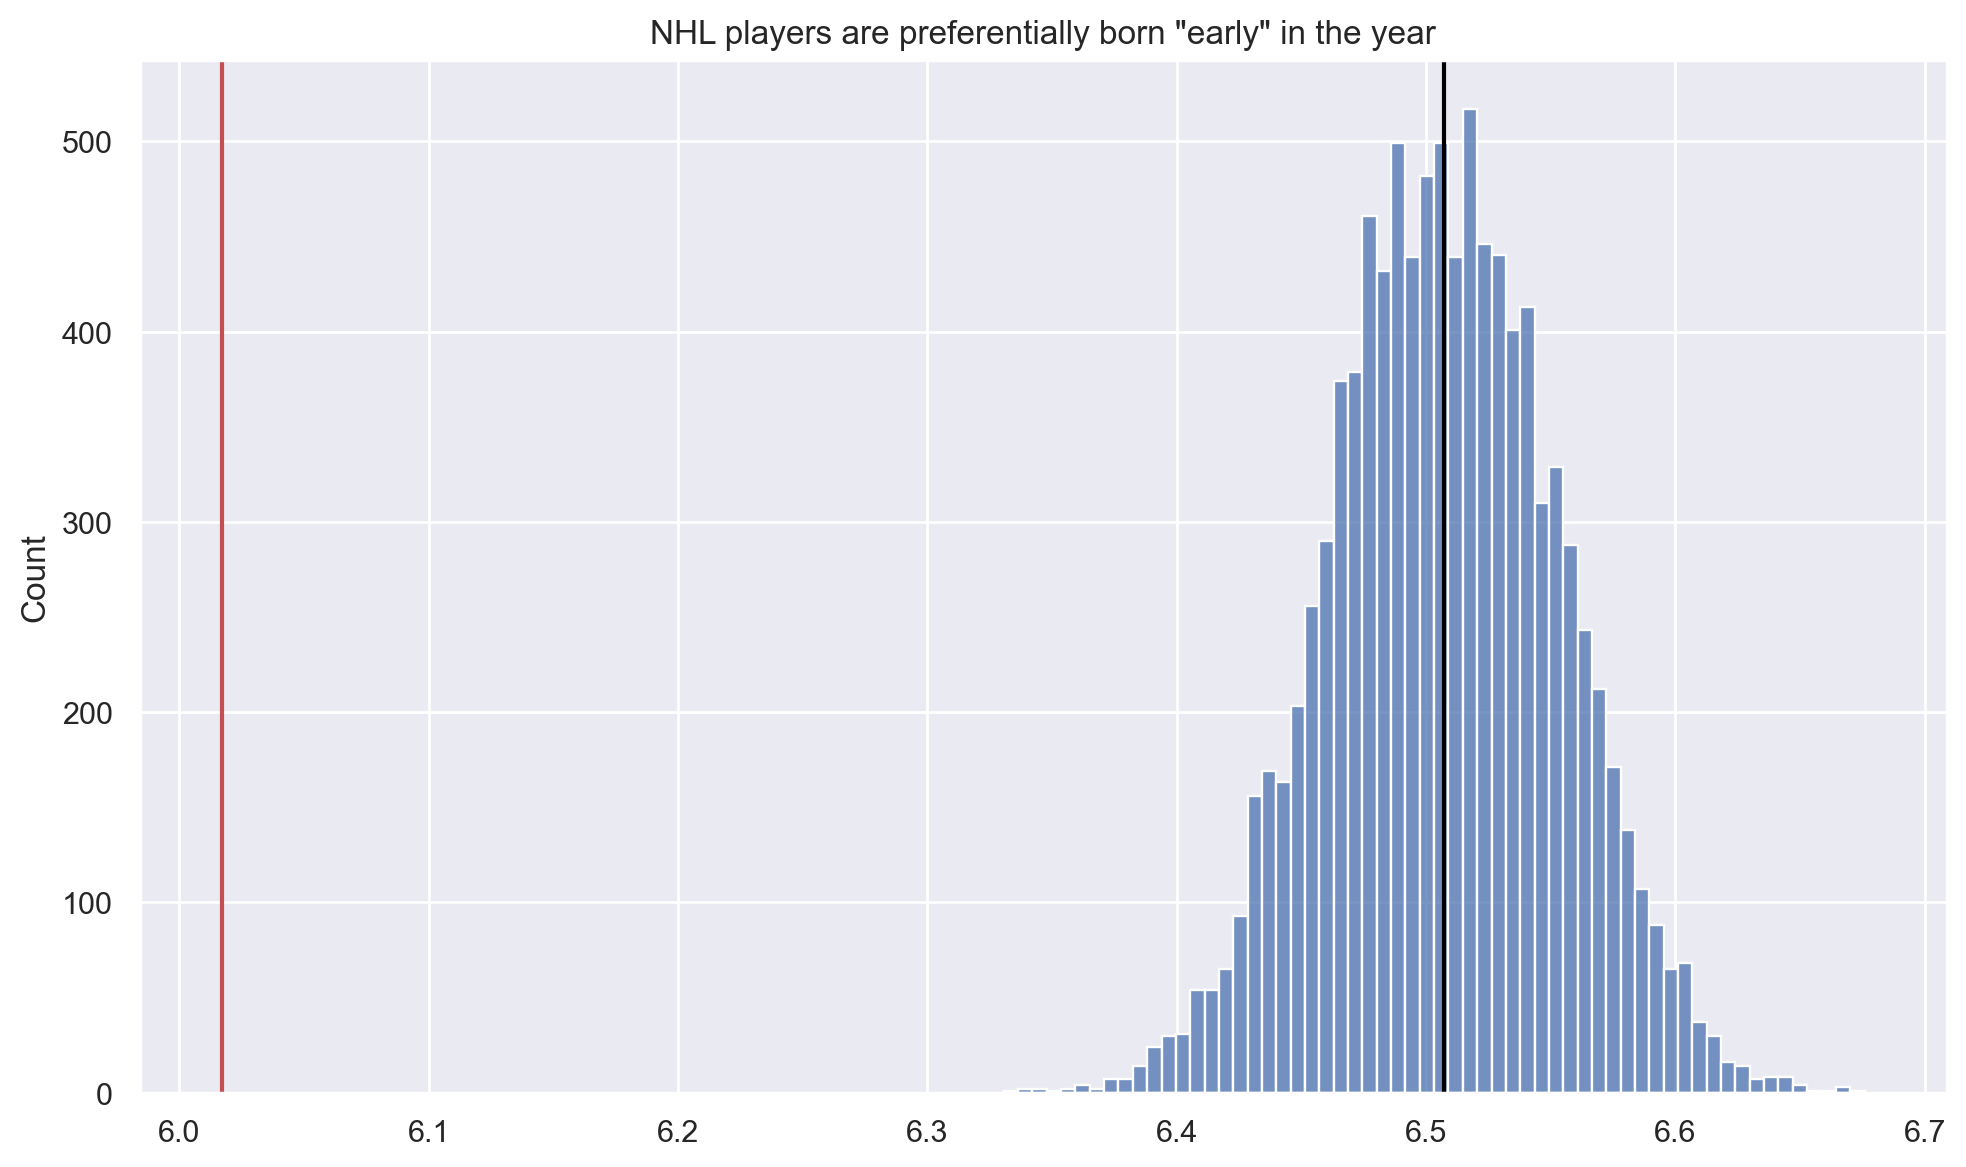

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")
sns.histplot(weights, ax=ax)
ax.axvline(
    calculate_metric(canadian_players_by_birth["birth_month"], linear_weight),
    color=sns.color_palette()[3],
)
ax.axvline(
    np.average(weights), # if perfectly balanced 
    color='black',
)
ax.set_title(f'NHL players are preferentially born "early" in the year')
fig.tight_layout()

## Plan: create a live dashboard with some kind of interactivity

1. filter by Canadian born
2. filter by ~Candian born
3. don't filter (all)



## Don't run for now

In [25]:
```{shinylive-python}
#| standalone: true

from shiny import *

app_ui = ui.page_fluid(
    ui.input_slider("n", "N", 0, 100, 40),
    ui.output_text_verbatim("txt"),
)

def server(input, output, session):
    @output
    @render.text
    def txt():
        return f"The value of n*2 is {input.n() * 2}"

app = App(app_ui, server)

```

SyntaxError: invalid syntax (918194286.py, line 1)

In [ ]:

    @output
    @render.plot
    def plot():
        
        return fig


from pathlib import Path

import pandas
from shiny import App, render, ui

app_ui = ui.page_fluid(
    ui.input_checkbox_group( 
        "checkbox_group", 
        "Birth Countries", 
        { 
            "born_canada": "Born in Canada",
            "not_born_canada": "Not born in Canada",
        }, 
    ),
)


def server(input, output, session):
    @output
    @render.table
    def table():
        infile = Path(__file__).parent / "mtcars.csv"
        df = pandas.read_csv(infile)
        # Use the DataFrame's to_html() function to convert it to an HTML table, and
        # then wrap with ui.HTML() so Shiny knows to treat it as raw HTML.
        return df


app = App(app_ui, server)


In [ ]:
from shiny import App, render, req, ui

app_ui = ui.page_fluid(
    ui.input_checkbox_group( 
        "checkbox_group", 
        "Checkbox group", 
        { 
            "a": "A", 
            "b": "B", 
            "c": "C", 
        }, 
    ), 
    ui.output_text("value"),
)

def server(input, output, session):
    @render.text
    def value():
        return ", ".join(input.checkbox_group())

app = App(app_ui, server)

### Reproduce the visual

## Questions

- Should I exclusively look at NHL players born in Canada?
- Should I weight the overall Canada birth rate based on NHL player density?
    - I think yes, and I can do it by sampling based on player's birth year.
- Should I slice active players by season (year)? As in, over time is the effect changing?

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()